In [164]:
# Load packages and directories


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.subplots as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import seaborn as sns
import importlib

import synthetic_profile_formulas_testing as spf
import re

base_directory = "C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning"
data_directory = os.path.join(base_directory, 'edp_data')
cleaned_data_directory = os.path.join(base_directory, 'resampled_30min_data')

# Directory containing the household profile CSV files
survey_data = pd.read_csv(os.path.join(base_directory, 'survey/edp_survey_aircon.csv'))  
output_directory = os.path.join(base_directory, 'figures')  # Change this to your output directory


In [165]:
predicted_response_classes = pd.read_csv(os.path.join(base_directory, 'predicted_response_classes.csv'))
testing_df = pd.read_csv(os.path.join(base_directory, 'combined_aircon_profiles_testing.csv'))
# create wide profile with all profiles with site id, date, and times as columns
# regression_df has site_id, date, and profile_class as columns FOR EVERY SITE
regression_df = pd.read_csv(os.path.join(base_directory, 'df_for_regression_testing.csv'))

In [185]:
print(regression_df)

             date  weather_station_number  max_air_temperature  \
0      2023-01-01                 85296.0                 30.3   
1      2023-01-02                 85296.0                 30.7   
2      2023-01-03                 85296.0                 15.8   
3      2023-01-04                 85296.0                 14.7   
4      2023-01-05                 85296.0                 17.6   
...           ...                     ...                  ...   
17150  2023-12-27                 63291.0                 23.3   
17151  2023-12-28                 63291.0                 27.7   
17152  2023-12-29                 63291.0                 24.2   
17153  2023-12-30                 63291.0                 24.7   
17154  2023-12-31                 63291.0                 20.8   

       min_air_temperature site_ID  postcode state property_construction  \
0                     16.7   W0087      3858   VIC          Brick veneer   
1                     16.3   W0087      3858   VIC     

In [199]:
merged_regression_df = pd.read_csv(os.path.join(base_directory, 'merged_regression_and_consumption_df.csv'))
testing_site_ids = testing_df.columns.drop(['Timestamp'])

In [200]:
print(testing_site_ids)

Index(['S0576', 'W0236', 'W0220', 'S0177', 'W0087', 'W0058', 'W0334', 'W0031',
       'W0142', 'S0209', 'W0328', 'S0463', 'W0241', 'S0299', 'W0321', 'W0138',
       'S0229', 'W0061', 'W0329', 'S0249', 'W0326', 'S0179', 'W0037', 'W0158',
       'W0275', 'S0250', 'W0017', 'W0227', 'W0014', 'S0227', 'W0137', 'S0568',
       'S0392', 'W0118', 'W0082', 'W0195', 'W0181', 'S0216', 'W0293', 'W0213',
       'W0172', 'W0166', 'W0081', 'S0509', 'W0266', 'W0342', 'W0011', 'W0073'],
      dtype='object')


In [207]:
merged_regression_df = merged_regression_df[~merged_regression_df['site_ID'].isin(testing_site_ids)]

In [ ]:
print(merged_regression_df)

In [221]:
importlib.reload(spf)

def create_bootstrapped_real_merged_df(testing_site_ids, testing_df, predicted_response_classes, regression_df, merged_regression_df, max_threshold=45, min_threshold=0, reverse_cycle=0, ramp_rate_constraint = 0.5):
    
    # create df with timestamp 
    bootstrapped_real_merged_df = pd.DataFrame()
    
    for site_ID in testing_site_ids:
        print("Processing site ID:", site_ID)
        original_df = pd.read_csv(os.path.join(base_directory, 'resampled_30min_data', f'{site_ID}_profile.csv'))

        sample_results = spf.sample_profile_class_testing(
            combined_df=testing_df, regression_df=predicted_response_classes, 
            site_ID=site_ID
        )
        new_sample_results = spf.update_profile_class_testing(regression_df, sample_results, site_ID, reverse_cycle, min_threshold, max_threshold)
        
        print("Bootstrapping site ID: ", site_ID)
        bootstrapped_df = spf.bootstrap_daily_profiles_testing(new_sample_results, merged_regression_df, ramp_rate_constraint)
        unscaled_df = spf.melt_and_undo_minmax_scaling(bootstrapped_df, testing_df, original_df, site_ID)
                # If this is the first site, use its timestamp as the index for the merged df
        if bootstrapped_real_merged_df.empty:
            bootstrapped_real_merged_df['datetime'] = unscaled_df['datetime']
            bootstrapped_real_merged_df.set_index('datetime', inplace=True)
        
        # Add bootstrapped and real values for this site with unique column names
        bootstrapped_real_merged_df[f'{site_ID}_bootstrapped'] = unscaled_df['bootstrapped_value'].values
        bootstrapped_real_merged_df[f'{site_ID}_real'] = unscaled_df['real_value'].values
    
    # Reset index to make timestamp a column again if needed
    bootstrapped_real_merged_df.reset_index(inplace=True)
    
    return bootstrapped_real_merged_df

In [222]:
bootstrapped_real_merged_df = create_bootstrapped_real_merged_df(testing_site_ids, testing_df, predicted_response_classes, regression_df, merged_regression_df, max_threshold=28, min_threshold=21, reverse_cycle=0)


Processing site ID: S0576

Condition checks:
Records where max_air_temperature > 21: 184
Records where max_air_temperature < 28: 307
Records where both conditions are met: 126
Bootstrapping site ID:  S0576


ValueError: No profiles found for Class_6.0

In [176]:
print(bootstrapped_real_merged_df.head())

             datetime  S0227_bootstrapped  S0227_real
0 2023-01-01 00:00:00            0.008733    0.230968
1 2023-01-01 00:30:00            0.008773    0.089642
2 2023-01-01 01:00:00            0.008837    0.089667
3 2023-01-01 01:30:00            0.008822    0.089479
4 2023-01-01 02:00:00            0.008887    0.089579


Visualizations

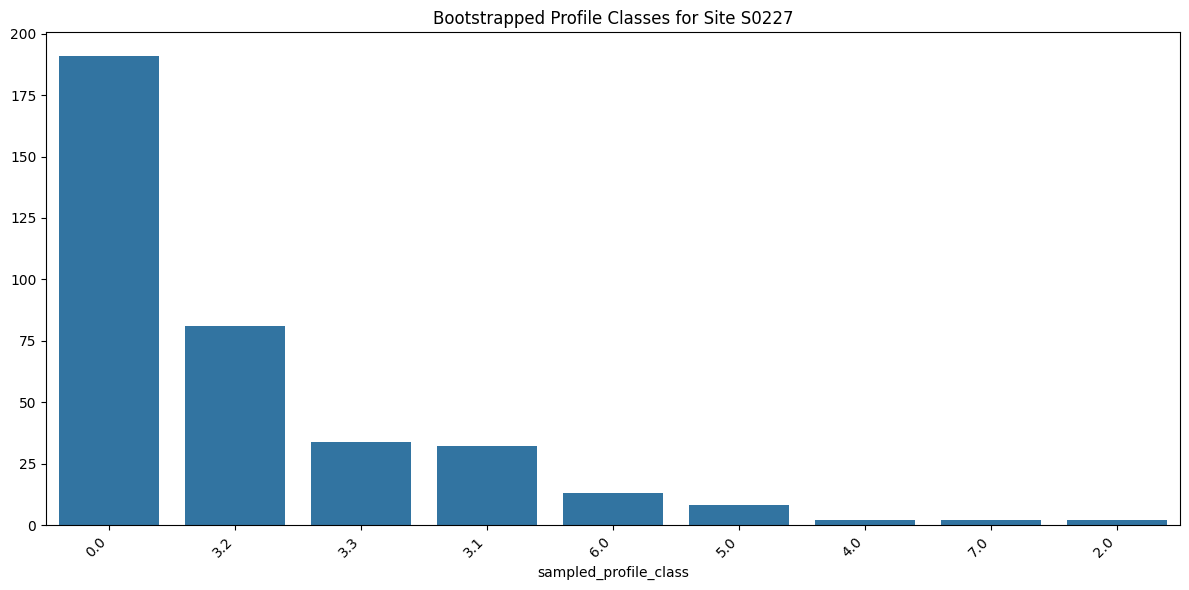

In [96]:
# Calculate counts for both columns
bootstrapped_counts = sample_results['sampled_profile_class'].value_counts()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot for 'bootstrapped_profile_class'
sns.countplot(
    data=sample_results,
    x='sampled_profile_class',
    order=bootstrapped_counts.index,
    ax=ax
)
ax.set_title("Bootstrapped Profile Classes for Site {site_id}".format(site_id=site_ID))
ax.set_ylabel("")  # Remove y-axis label for aesthetics
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [ ]:
importlib.reload(spf)
# default max threshold is 45, default min threshold is 0

reverse_cycle = 1   # 0 = No Reverse Cycle, cooling only, 1 = Reverse Cycle, heating and cooling
max_threshold = 27
min_threshold = 21
new_sample_results = spf.update_profile_class_testing(regression_df, sample_results, site_ID, reverse_cycle, min_threshold, max_threshold)


In [151]:
importlib.reload(spf)
ramp_rate_constraint = 0.50

bootstrapped_df = spf.bootstrap_daily_profiles_testing(new_sample_results, merged_regression_df, ramp_rate_constraint)

In [116]:
print(bootstrapped_df.head())

        date sampled_profile_class temp_sampled_profile_class  \
0 2023-01-01                   3.1                        3.1   
1 2023-01-02                   6.0                        6.0   
2 2023-01-03                   3.2                        3.2   
3 2023-01-04                   0.0                        0.0   
4 2023-01-05                   4.0                        4.0   

   min_air_temperature  max_air_temperature  00:00:00  00:30:00  01:00:00  \
0                 16.2                 34.9  0.000000  0.000000  0.000000   
1                 17.0                 31.6  0.045220  0.044018  0.042124   
2                 14.4                 20.6  0.010132  0.010203  0.010189   
3                 13.4                 16.5  0.000383  0.000403  0.000378   
4                 13.1                 20.8  0.333372  0.314789  0.301869   

   01:30:00  02:00:00  ...  19:00:00  19:30:00  20:00:00  20:30:00  21:00:00  \
0  0.000000  0.000000  ...  0.000000  0.019231  0.000000  0.000000

             datetime  bootstrapped_value temp_sampled_profile_class  \
0 2023-01-01 00:00:00            0.183804                        3.1   
1 2023-01-01 00:30:00            0.074135                        3.1   
2 2023-01-01 01:00:00            0.165196                        3.1   
3 2023-01-01 01:30:00            0.464639                        3.1   
4 2023-01-01 02:00:00            0.074030                        3.1   

   real_value  
0    0.046443  
1    0.018025  
2    0.018030  
3    0.017993  
4    0.018013  


In [ ]:

site_ID = site_ID
unscaled_df_real_and_bootstrapped = spf.undo_minmax_scaling(df_real_and_bootstrapped, site_ID)

In [144]:
# Interactive line plot with Plotly
fig = px.line(
    df_real_and_bootstrapped,
    x='datetime',
    y='bootstrapped_value',
    title='Interactive Bootstrapped Air Conditioner Profile for Site {site_id}'.format(site_id=site_ID),
    labels={'datetime': 'Datetime', 'value': 'Electricity Consumption (scaled 0-1)'},
    hover_data=['temp_sampled_profile_class'],
)

# Update layout for better visibility
fig.update_layout(
    xaxis_title='Date time',
    yaxis_title='Electricity Consumption (scaled 0-1)',
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    legend_title='Sampled Profile Class',
    hovermode='x unified',
    template='plotly'
)


# Show the interactive plot
fig.show()

In [145]:
# Interactive line plot with Plotly
fig = px.line(
    df_real_and_bootstrapped,
    x='datetime',
    y='real_value',
    title='Interactive Bootstrapped Air Conditioner Profile for Site {site_id}'.format(site_id=site_ID),
    labels={'datetime': 'Datetime', 'value': 'Electricity Consumption (scaled 0-1)'},
    hover_data=['temp_sampled_profile_class'],
)

# Update layout for better visibility
fig.update_layout(
    xaxis_title='Date time',
    yaxis_title='Electricity Consumption (scaled 0-1)',
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    legend_title='Sampled Profile Class',
    hovermode='x unified',
    template='plotly'
)


# Show the interactive plot
fig.show()

Graveyard

In [ ]:

# irrelevant piece of info actually 
# importlib.reload(spf)

# # merged_df has Site_ID, Date and every timestamp and household characteristics including Profile_Class   for EVERY SITE
# merged_df = spf.merge_and_pivot_dataframes_testing(testing_df, regression_df)
# merged_regression_df = merged_df.copy()


# if not os.path.exists(os.path.join(base_directory, 'testing_merged_regression_and_consumption_df.csv')):
#     merged_regression_df.to_csv(os.path.join(base_directory, 'testing_merged_regression_and_consumption_df.csv'), index=False)
#     print(f'File written: testing_merged_regression_and_consumption_df.csv')
# else:
#     print('File already exists!')

# print(merged_regression_df.head())

In [ ]:


# Melt the DataFrame
df_melted = bootstrapped_df.melt(id_vars=['date', 'temp_sampled_profile_class', 'sampled_profile_class', 'min_air_temperature', 'max_air_temperature'],
                    var_name='time', value_name='value')

# convert date column into a string
df_melted['date'] = df_melted['date'].astype(str)
df_melted['time'] = df_melted['time'].astype(str)
# drop min and max air temperature columns
df_melted.drop(columns=['min_air_temperature', 'max_air_temperature'], inplace=True)


# arrange df_melt by date and then time and then combine the two columns
df_melted['datetime'] = pd.to_datetime(df_melted['date'] + ' ' + df_melted['time'])
df_melted['datetime'] = pd.to_datetime(df_melted['datetime'])

df_melted = df_melted.sort_values(by=['datetime'])
df_melted = df_melted[['datetime', 'value', 'temp_sampled_profile_class']].reset_index(drop=True)

df_filtered = testing_df[['Timestamp', site_ID]]
# Merge df_filtered and df_melted on 'datetime' and 'Timestamp'
df_filtered['datetime'] = pd.to_datetime(df_filtered['Timestamp'])
df_filtered = df_filtered.drop(columns=['Timestamp'])

df_real_and_bootstrapped = pd.merge(df_melted, df_filtered, on='datetime', how='inner')

# Drop the redundant 'Timestamp' column

df_real_and_bootstrapped.rename(columns={site_ID: 'real_value', 'value': 'bootstrapped_value'}, inplace=True)